# Getting started:

# Importing Libraries:

In [2]:
# Install necessary libraries
!pip install keras-tuner

# Import required libraries
import os
import numpy as np
import pandas as pd
import cv2
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Conv2D, Multiply, Add, GlobalAveragePooling2D,
    GlobalMaxPooling2D, Reshape, Dense
)

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Keras Tuner
import keras_tuner as kt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt

In [4]:
!pip install keras-tuner

In [5]:
!unzip '/content/archive.zip'

Archive:  /content/archive.zip
  inflating: Braille Dataset/Braille Dataset/a1.JPG0dim.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG0rot.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG0whs.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG10dim.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG10rot.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG10whs.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG11dim.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG11rot.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG11whs.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG12dim.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG12rot.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG12whs.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG13dim.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG13rot.jpg  
  inflating: Braille Dataset/Braille Dataset/a1.JPG13whs.jpg  
  inflating: Braille Datase

In [6]:
tf.__version__

'2.18.0'

# Preprocessing:

In [7]:
image_dir = Path('/content/Braille Dataset/Braille Dataset')

In [8]:
dir_list = list(image_dir.glob('*.jpg'))

In [9]:
image_count = len(dir_list)
image_count

1560

In [10]:
name_list = []
for i in dir_list:
    name_list.append(os.path.basename(i)[0])

In [11]:
images = []
for dir in dir_list:
    I = cv2.imread(str(dir))
    images.append(I)

In [12]:
images_list = np.array(images)
name_list = np.array(name_list).T

In [13]:
le = LabelEncoder()
name_list_encoded = le.fit_transform(name_list)
images_list = images_list / 255.0

In [14]:
images_list.shape

(1560, 28, 28, 3)

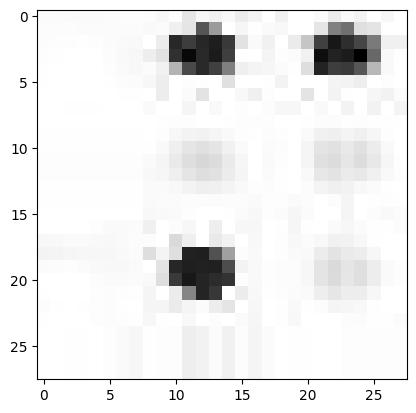

In [15]:
plt.imshow(images_list[0])

In [16]:
images_list.shape

(1560, 28, 28, 3)

In [17]:
name_list_encoded.shape

(1560,)

# Splitting in train and test data:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images_list, name_list_encoded, test_size=0.2, random_state=42)

# Creating model:

In [19]:
# Optimized CBAM Attention Module for Braille Character Recognition
class CBAM(layers.Layer):
    def __init__(self, filters, reduction=8):  # Reduced reduction ratio for better feature retention
        super(CBAM, self).__init__()

        # Channel Attention
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.fc1 = layers.Dense(filters // reduction, activation='relu')
        self.fc2 = layers.Dense(filters, activation='sigmoid')

        # Spatial Attention
        self.conv_spatial = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Channel Attention
        avg_out = self.fc2(self.fc1(self.avg_pool(inputs)))
        max_out = self.fc2(self.fc1(self.max_pool(inputs)))
        channel_attention = tf.reshape(avg_out + max_out, (-1, 1, 1, inputs.shape[-1]))
        channel_refined = inputs * channel_attention

        # Spatial Attention
        spatial_attention = self.conv_spatial(channel_refined)
        refined_output = channel_refined * spatial_attention
        return refined_output

# Optimized CNN Model with Enhanced CBAM for Braille Recognition
model = keras.Sequential([
    layers.Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0015)),
    CBAM(64),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0015)),
    CBAM(128),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0013)),
    CBAM(128),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0013)),
    CBAM(256),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0011)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0011)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(26, activation='softmax')
])


In [20]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', 'sparse_categorical_accuracy'])


In [21]:
# model.compile(optimizer='Adam', loss="SparseCategoricalCrossentropy", metrics=["accuracy","sparse_categorical_accuracy"])

In [22]:
# es1 = EarlyStopping(patience=20, monitor="val_accuracy", mode="max")
# es2 = EarlyStopping(patience=20, monitor="val_loss", mode="min")


# history = model.fit(x=X_train,
#                     y=y_train,
#                     epochs=10000,
#                     validation_split=0.1,
#                     callbacks=[es1, es2])

In [25]:
es1 = callbacks.EarlyStopping(patience=150, monitor="val_accuracy", mode="max", min_delta=0.001, restore_best_weights=True)
es2 = callbacks.EarlyStopping(patience=150, monitor="val_loss", mode="min", min_delta=0.001, restore_best_weights=True)

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=250,
                    validation_split=0.1,
                    callbacks=[es1, es2])

Epoch 1/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9931 - loss: 0.8726 - sparse_categorical_accuracy: 0.9931 - val_accuracy: 0.9520 - val_loss: 1.0107 - val_sparse_categorical_accuracy: 0.9520
Epoch 2/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9913 - loss: 0.8804 - sparse_categorical_accuracy: 0.9913 - val_accuracy: 0.9520 - val_loss: 0.9742 - val_sparse_categorical_accuracy: 0.9520
Epoch 3/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9924 - loss: 0.8758 - sparse_categorical_accuracy: 0.9924 - val_accuracy: 0.9600 - val_loss: 1.0014 - val_sparse_categorical_accuracy: 0.9600
Epoch 4/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9902 - loss: 0.8743 - sparse_categorical_accuracy: 0.9902 - val_accuracy: 0.9680 - val_loss: 0.9557 - val_sparse_categorical_accuracy: 0.9680
Epoch 5/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9932 - loss: 0.8479 - sparse_categorical_accuracy: 0.9932 - val_accuracy: 0.9600 - val_loss: 0.9332 - 

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam (CBAM)                          │ (None, 28, 28, 64)          │           4,233 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam_1 (CBAM)                        │ (None, 28, 28, 128)         │          10,513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam_2 (CBAM)                        │ (None, 14, 14, 128)         │          10,513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam_3 (CBAM)                        │ (None, 7, 7, 256)           │          29,217 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │              

 Total params: 10,440,116 (39.83 MB)

 Trainable params: 3,478,630 (13.27 MB)

 Non-trainable params: 4,224 (16.50 KB)

 Optimizer params: 6,957,262 (26.54 MB)

In [28]:
time = np.arange(1, len(history.history['loss'])+1)


In [31]:
model.evaluate(X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - accuracy: 0.9504 - loss: 1.0414 - sparse_categorical_accuracy: 0.9504


[0.9728004336357117, 0.9647436141967773, 0.9647436141967773]

In [32]:
model.save('attention5bje.h5')

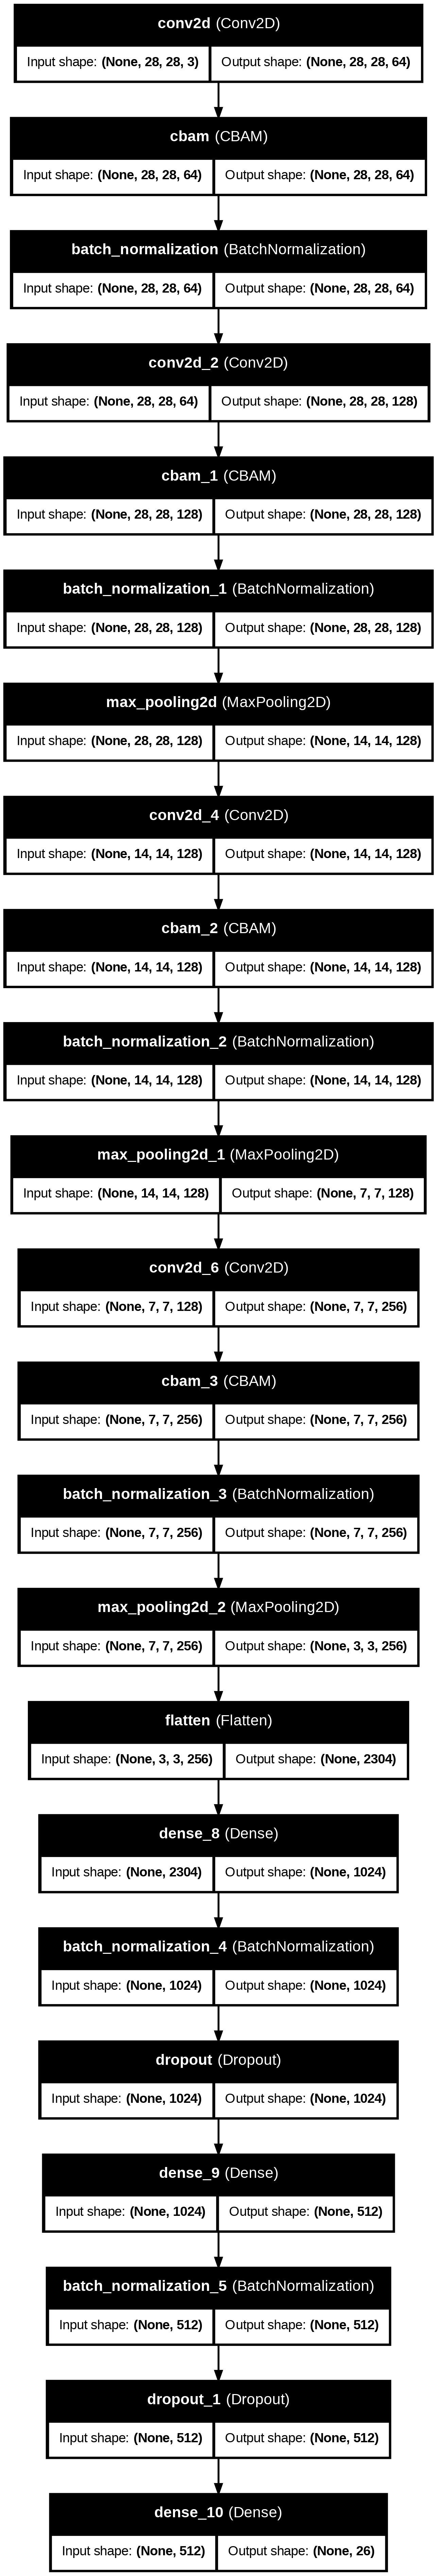

In [33]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Predicting the braille character by giving model and the input image


Model loaded successfully with CBAM.


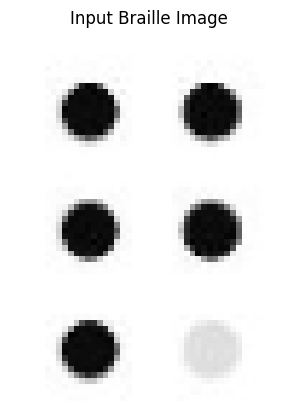

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Character: Q


In [38]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Add, Reshape, Multiply, Conv2D

def cbam_block(inputs, reduction_ratio=16):
    """ CBAM Module """
    # Channel Attention
    channel_avg = GlobalAveragePooling2D()(inputs)
    channel_max = GlobalMaxPooling2D()(inputs)

    shared_dense = Dense(inputs.shape[-1] // reduction_ratio, activation='relu')
    channel_avg = shared_dense(channel_avg)
    channel_max = shared_dense(channel_max)

    channel_attention = Add()([channel_avg, channel_max])
    channel_attention = Dense(inputs.shape[-1], activation='sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, inputs.shape[-1]))(channel_attention)

    x = Multiply()([inputs, channel_attention])

    # Spatial Attention
    spatial_avg = tf.reduce_mean(x, axis=-1, keepdims=True)
    spatial_max = tf.reduce_max(x, axis=-1, keepdims=True)
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(
        tf.concat([spatial_avg, spatial_max], axis=-1))

    output = Multiply()([x, spatial_attention])
    return output

# Load the model with CBAM layer
custom_objects = {'cbam_block': cbam_block}
model_path = '/content/attention5bje.h5'

try:
    model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully with CBAM.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# Function to preprocess Braille image
def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if img is None:
            raise ValueError(f"Error: Unable to read image at {img_path}")
        img = cv2.resize(img, (28, 28))  # Resize to model input size
        img = img / 255.0  # Normalize pixel values
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = np.repeat(img, 3, axis=-1)  # Convert to 3-channel format
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        return img
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return None

# Function to predict character from Braille image
def predict_braille(img_path, model):
    processed_img = preprocess_image(img_path)
    if processed_img is None:
        return "Error in image preprocessing."

    try:
        prediction = model.predict(processed_img)
        predicted_class = np.argmax(prediction)
        if 0 <= predicted_class <= 25:
            return chr(65 + predicted_class)  # Convert to uppercase letter
        else:
            return "Invalid Prediction"
    except Exception as e:
        return f"Error in prediction: {e}"

# Function to display input image
def display_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Unable to read image at {img_path}")
        return
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Input Braille Image")
    plt.show()

# Example usage
if __name__ == "__main__":
    img_path = '/content/q.png'  # Replace with actual image path
    display_image(img_path)  # Show input image
    result = predict_braille(img_path, model)
    print(f'Predicted Character: {result}')


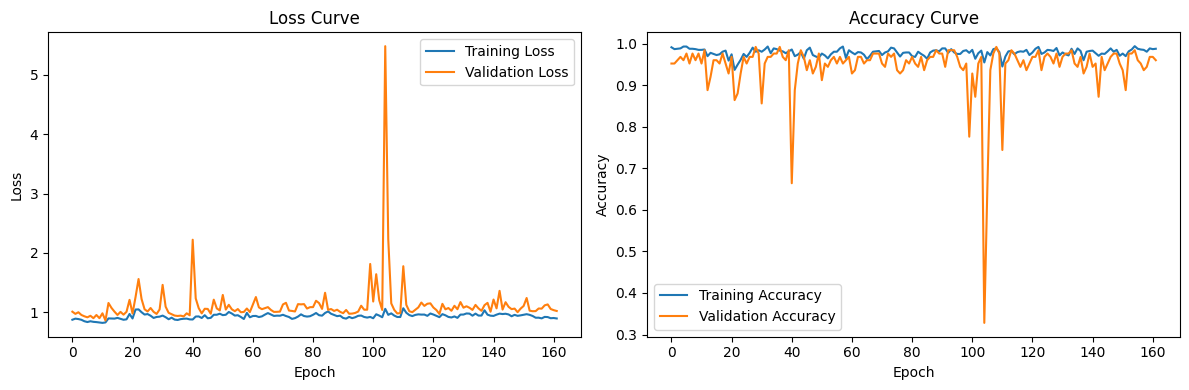

In [35]:
# prompt: give me the code for accuracy/loss curve for this model

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Model loaded successfully!
Dataset extracted successfully!
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
Classification Report:
               precision    recall  f1-score   support

           a       1.00      1.00      1.00       120
           b       1.00      1.00      1.00       120
           c       0.94      1.00      0.97       120
           d       0.98      1.00      0.99       120
           e       1.00      0.98      0.99       120
           f       0.98      1.00      0.99       120
           g       1.00      1.00      1.00       120
           h       1.00      0.98      0.99       120
           i       0.98      0.95      0.97       120
           j       1.00      1.00      1.00       120
           k       1.00      0.98      0.99       120
           l       1.00      1.00      1.00       120
           m       1.00      1.00      1.00       120
           n       0.97      1.00      0.98       120
           o       1.00      1.00      1.00       120
           p

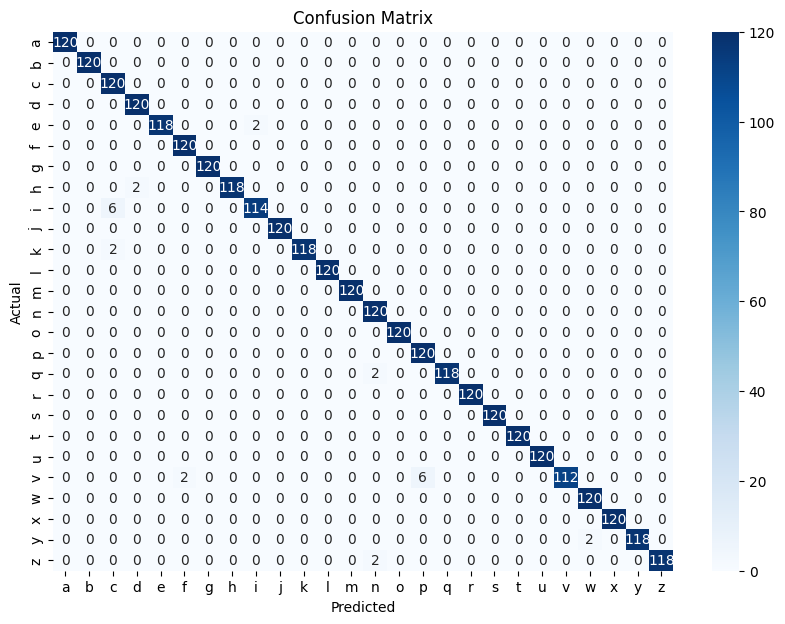

In [36]:

# bdsuybfvifdsbfuishduifhusidh



import os
import numpy as np
import pandas as pd
import cv2
import zipfile
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Layer, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------
# Define CBAM Attention Layer
# ----------------------
class CBAM(Layer):
    def __init__(self, filters, reduction=8, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.filters = filters
        self.reduction = reduction

        # Channel Attention
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()
        self.fc1 = Dense(filters // reduction, activation='relu')
        self.fc2 = Dense(filters, activation='sigmoid')

        # Spatial Attention
        self.conv_spatial = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Channel Attention
        avg_out = self.fc2(self.fc1(self.avg_pool(inputs)))
        max_out = self.fc2(self.fc1(self.max_pool(inputs)))
        channel_attention = tf.reshape(avg_out + max_out, (-1, 1, 1, inputs.shape[-1]))
        channel_refined = inputs * channel_attention

        # Spatial Attention
        spatial_attention = self.conv_spatial(channel_refined)
        refined_output = channel_refined * spatial_attention
        return refined_output

    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({"filters": self.filters, "reduction": self.reduction})
        return config

# Register custom layer
get_custom_objects().update({"CBAM": CBAM})

# ----------------------
# Load Model
# ----------------------
model_path = "/content/attention5bje.h5"
model = load_model(model_path, custom_objects={"CBAM": CBAM})
print("Model loaded successfully!")

# ----------------------
# Extract Dataset
# ----------------------
dataset_zip_path = "/content/archive.zip"
extract_path = "/content/Braille Dataset/Braille Dataset"

# Extract dataset
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted successfully!")

# ----------------------
# Load and Preprocess Dataset
# ----------------------
IMG_SIZE = (28, 28)
X_test, y_test = [], []

# Read dataset
for root, _, files in os.walk(extract_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # Normalize pixel values
            X_test.append(img)
            y_test.append(file_name[0])  # Extract label from filename

# Convert to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Encode labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# ----------------------
# Model Prediction & Evaluation
# ----------------------
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate classification report
class_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


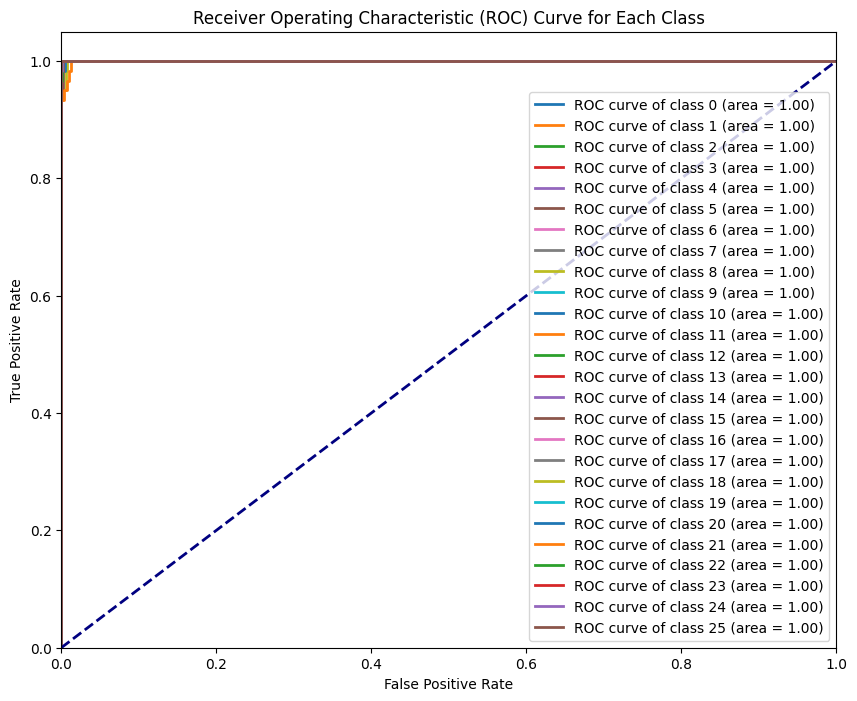

In [41]:
# prompt: give me code for ROC curve for all the 26 classes that are in this model

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ... (Your existing code for loading the model and dataset) ...

# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

# Binarize the labels for ROC curve calculation
y_test_bin = label_binarize(y_test_encoded, classes=np.arange(26))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class %d (area = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()
